# Определение стоимости автомобилей

Целью данной работы является создание модели предсказания цены автомобиля для приложения сервиса "Не бит, не крашен". Модель по переданным данным должна предсказывать рыночную цену для автомобиля пользователя.

Нам предоставлены исторические данные с техническими характеристиками, комплектациями и ценами автомобилей. В данных имеются аномальные значения, пропуски, бесполезные признаки (с точки зрения полезности для прогнозирования). Нам необходимо привести данные в порядок, разбить данные на подвыборки (так как отдельной тестовой выборки у нас не имеется). 

После необходимо обучить несколько моделей предсказания, одной из которых должна быть модель градиентного бустинга, обученная библиотекой LightGBM. Обученные модели должны соответствовать определенным критериям заказчика:

- **показатель качества модели** - качество следует измерять метрикой RMSE, в итоговой модели должно быть не выше 2500;


- **время обучения модели**;


- **время предсказания**.

**Описание данных:**

- **DateCrawled** — дата скачивания анкеты из базы
- **VehicleType** — тип автомобильного кузова
- **RegistrationYear** — год регистрации автомобиля
- **Gearbox** — тип коробки передач
- **Power** — мощность (л. с.)
- **Model** — модель автомобиля
- **Kilometer** — пробег (км)
- **RegistrationMonth** — месяц регистрации автомобиля
- **FuelType** — тип топлива
- **Brand** — марка автомобиля
- **Repaired** — была машина в ремонте или нет
- **DateCreated** — дата создания анкеты
- **NumberOfPictures** — количество фотографий автомобиля
- **PostalCode** — почтовый индекс владельца анкеты (пользователя)
- **LastSeen** — дата последней активности пользователя

**Целевой признак** - Price — цена (евро)

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Загрузка-данных-и-библиотек" data-toc-modified-id="Загрузка-данных-и-библиотек-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Загрузка данных и библиотек</a></span></li><li><span><a href="#Изменение-названий-столбцов,-работа-с-пропущенными-значениями" data-toc-modified-id="Изменение-названий-столбцов,-работа-с-пропущенными-значениями-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Изменение названий столбцов, работа с пропущенными значениями</a></span></li><li><span><a href="#Удаление-аномальных-значений" data-toc-modified-id="Удаление-аномальных-значений-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Удаление аномальных значений</a></span></li><li><span><a href="#OrdinalEncoding-для-категориальных-значений" data-toc-modified-id="OrdinalEncoding-для-категориальных-значений-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>OrdinalEncoding для категориальных значений</a></span></li></ul></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#AdaBoost" data-toc-modified-id="AdaBoost-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>AdaBoost</a></span></li><li><span><a href="#Random-Forest" data-toc-modified-id="Random-Forest-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Random Forest</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>LightGBM</a></span></li></ul></li><li><span><a href="#Анализ-моделей" data-toc-modified-id="Анализ-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ моделей</a></span><ul class="toc-item"><li><span><a href="#AdaBoost" data-toc-modified-id="AdaBoost-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>AdaBoost</a></span></li><li><span><a href="#Random-Forest" data-toc-modified-id="Random-Forest-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Random Forest</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>LightGBM</a></span></li></ul></li><li><span><a href="#Проверка-качества-на-тестовых-данных" data-toc-modified-id="Проверка-качества-на-тестовых-данных-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Проверка качества на тестовых данных</a></span></li><li><span><a href="#Общий-вывод-по-работе" data-toc-modified-id="Общий-вывод-по-работе-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод по работе</a></span></li></ul></div>

## Подготовка данных

### Загрузка данных и библиотек

In [1]:
# необходимые библиотеки
# импортируем необходимые библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import KNNImputer
from lightgbm import LGBMRegressor
from sklearn.ensemble import AdaBoostRegressor

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
# если можно, открываем файл из локального носителя
# или с Jupyter Hub
try:
    df = pd.read_csv('autos.csv')
except:
    df = pd.read_csv('/datasets/autos.csv')

In [3]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

В таблице 16 столбцов и 354369 значений. 

Наблюдаются пропуски в колонках `VehicleType`,`Gearbox`,`Model`,`FuelType`,`Repaired`. Названия колонок написаны в стиле CamelCase, что не является стандартной записью. На следующем шаге приведем названия столбцов к стандарту, заполним по возможности пропуски.

### Изменение названий столбцов, работа с пропущенными значениями

Сразу уберем явные дубликаты:


In [5]:
df = df.drop_duplicates()

Меняем названия колонок согласно стандарту:

In [6]:
df_columns = []
for col in df.columns:
    a = ''
    for i in range(len(col)):
        if col[i].isupper() and i != 0:
            a += '_'
            a += col[i]
        else:
            a += col[i]
    df_columns.append(a.lower())

In [7]:
df.columns = df_columns

**Поработаем с пропусками.**

В колонке "model" удалим строки с пропусками: нам неоткуда взять модель автомобиля, мы не можем нигде взять эту информацию. Также мы поступим с пропусками в колонке "gearbox": коробка передач также может быть разной у одной и той же модели. При этом заглушкой ("unknown") заполнять будет нецелесообразно.

Удаление этих строк повлечет за собой удаления около 10% от всех данных, что не является критическим в нашем случае, так как заполнение этих строк синтетическими данными может оказать негативное влияние на качество построенных моделей.

Пропуски в колнке "repaired" заполним заглушкой "unknown".

In [8]:
df = df.query('model == model').reset_index(drop=True)
df = df.query('gearbox == gearbox').reset_index(drop=True)
df['repaired'] = df['repaired'].fillna('unknown')

Пропуски в колонках "vehicle_type" и "fuel_type" будем заполнять с помощью KNN Imputer, предварительно трансформируя данные в этих колонках с помощью OrdinalEncoder. Для заполнения пропусков в этих колонках мы выберем только значимые для этих колонок фичи, пояснение:

- "vehicle_type" и "fuel_type"- явно на тип авто и тип топлива являют такие хар-ки как "registration_year"(год регистрации), "gearbox"(коробка передач), "power"(количество л.с.), "model"(модель), "brand"(марка).

Также следует обратить внимание на значения в колонке `"fuel_type"`: `gasoline` и `petrol` - это бензин. Выберем какое-то одно обозначение, чтобы не путать будущую модель:

In [9]:
df['fuel_type'] = df['fuel_type'].map({'gasoline':'petrol',
                                      'petrol':'petrol',
                                      'lpg':'lpg',
                                      'other':'other',
                                      'hybrid':'hybrid',
                                      'cng':'cng',
                                      'electric':'electric'}, na_action='ignore')

In [10]:
# Проверим изменения
df['fuel_type'].unique()

array(['petrol', nan, 'lpg', 'other', 'hybrid', 'cng', 'electric'],
      dtype=object)

Прежде чем использовать OrdinalEncoder удалим явно ненужные для построения модели столбцы: 

- "date_crawled" - дата скачивания анкеты.
- "date_created" - дата создания анкеты.
- "last_seen" - дата последней активности пользователя.

In [11]:
df = df.drop(columns=['date_crawled','date_created','last_seen'])

Далее заполнение пропусков с помощью KNNImputer:

In [12]:
# Если при выполнении ячейки вылетает ошибка, пожалуйста, перезапустите ядро и повторите снова
# (предустановленная версия sklearn не предусматривает выполнение OrdinalEncoder на данных с Nan-значениями
# поэтому sklearn был обновлен в ячейке выше)

onehotencoder = OrdinalEncoder()
df_for_na = df[["registration_year", "gearbox", "power", "model", "brand","vehicle_type","fuel_type"]]
df_one_hot_for_na = onehotencoder.fit_transform(
    df_for_na[['gearbox','model','brand','fuel_type','vehicle_type']].values)

        
df_one_hot_for_na = pd.DataFrame(df_one_hot_for_na, columns=['gearbox','model','brand','fuel_type','vehicle_type'])

In [13]:
# добавим новые столбцы в наши данные
df_for_na = pd.concat([df_for_na.drop(columns=['gearbox','model','brand','fuel_type','vehicle_type']), df_one_hot_for_na], axis=1)
df_for_na

,registration_year,power,gearbox,model,brand,fuel_type,vehicle_type
0,1993,0,1.0,116.0,37.0,5.0,NaN
1,2004,163,0.0,117.0,14.0,5.0,6.0
2,2001,75,1.0,116.0,37.0,5.0,5.0
3,2008,69,1.0,101.0,31.0,5.0,5.0
4,1995,102,1.0,11.0,2.0,5.0,4.0
...,...,...,...,...,...,...,...
318953,2000,0,1.0,249.0,24.0,5.0,0.0
318954,2005,0,1.0,78.0,22.0,5.0,NaN
318955,2000,101,0.0,106.0,32.0,5.0,1.0
318956,1996,102,1.0,224.0,37.0,5.0,0.0


In [14]:
# Данная ячейка выполняется 18 минут: прошу прощения за ожидание, это KNN.

# применяем импутер и перезаписываем в ту же таблицу
imputer = KNNImputer(n_neighbors=3)
df_for_na = pd.DataFrame(imputer.fit_transform(df_for_na), columns=df_for_na.columns)

In [15]:
# округляем полученные значения и переводим все значения столбца в int
df_for_na['fuel_type'] = df_for_na['fuel_type'].apply(lambda x: int(round(x)))
df_for_na['vehicle_type'] = df_for_na['vehicle_type'].apply(lambda x: int(round(x)))

In [16]:
df_new = onehotencoder.inverse_transform(df_for_na[['gearbox','model','brand','fuel_type','vehicle_type']])
df_new = pd.DataFrame(df_new, columns=['gearbox','model','brand','fuel_type','vehicle_type'])
df_new

,gearbox,model,brand,fuel_type,vehicle_type
0,manual,golf,volkswagen,petrol,other
1,auto,grand,jeep,petrol,suv
2,manual,golf,volkswagen,petrol,small
3,manual,fabia,skoda,petrol,small
4,manual,3er,bmw,petrol,sedan
...,...,...,...,...,...
318953,manual,zafira,opel,petrol,bus
318954,manual,colt,mitsubishi,petrol,small
318955,auto,fortwo,smart,petrol,convertible
318956,manual,transporter,volkswagen,petrol,bus


Перезаписываем данные без пропусков в исходную таблицу:

In [17]:
df['vehicle_type'] = df_new['vehicle_type']
df['fuel_type'] = df_new['fuel_type']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318958 entries, 0 to 318957
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               318958 non-null  int64 
 1   vehicle_type        318958 non-null  object
 2   registration_year   318958 non-null  int64 
 3   gearbox             318958 non-null  object
 4   power               318958 non-null  int64 
 5   model               318958 non-null  object
 6   kilometer           318958 non-null  int64 
 7   registration_month  318958 non-null  int64 
 8   fuel_type           318958 non-null  object
 9   brand               318958 non-null  object
 10  repaired            318958 non-null  object
 11  number_of_pictures  318958 non-null  int64 
 12  postal_code         318958 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 31.6+ MB


С пропусками разобрались, далее уберем выбросы и перекодируем категориальные данные.

### Удаление аномальных значений

7156 строк в исходных данных, где цена равна 0.

Такое значение явно аномально, удалим его вручную.

In [18]:
df.query('price == 0')

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,number_of_pictures,postal_code
6,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,0,19348
99,0,coupe,2017,manual,0,golf,5000,12,petrol,volkswagen,unknown,0,21698
135,0,bus,2004,manual,101,meriva,150000,10,lpg,opel,yes,0,27432
207,0,wagon,2001,manual,115,mondeo,150000,0,petrol,ford,unknown,0,57627
414,0,sedan,2016,auto,197,3er,150000,12,petrol,bmw,no,0,99867
...,...,...,...,...,...,...,...,...,...,...,...,...,...
318809,0,small,2000,manual,65,corsa,150000,0,petrol,opel,yes,0,23758
318838,0,small,2002,manual,60,fiesta,150000,3,petrol,ford,unknown,0,33659
318847,0,small,1999,manual,53,swift,150000,3,petrol,suzuki,unknown,0,42329
318874,0,small,1999,manual,37,arosa,150000,7,petrol,seat,yes,0,22559


In [19]:
df = df.query('price >= 50')

Остальные аномалии удалим на основании квартилей:

In [20]:
df.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'registration_month', 'fuel_type', 'brand',
       'repaired', 'number_of_pictures', 'postal_code'],
      dtype='object')

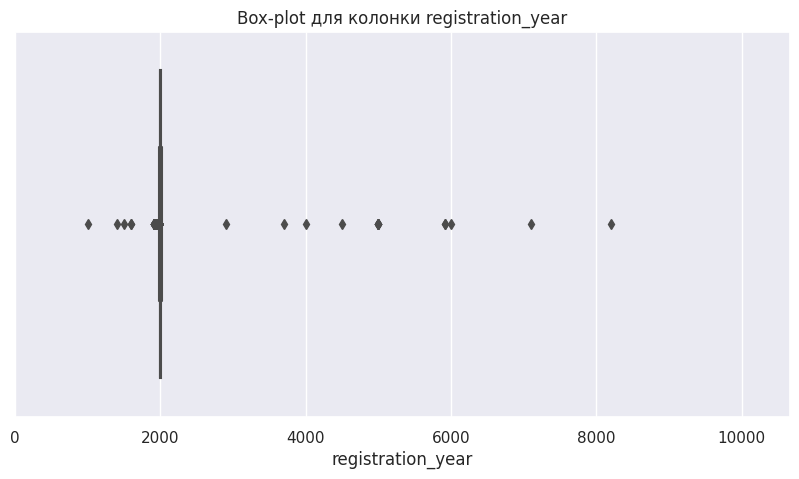

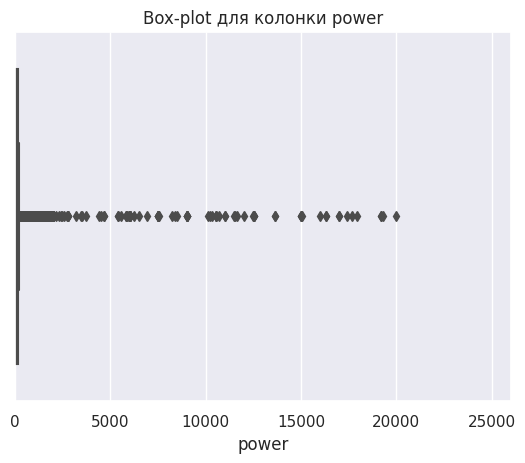

In [21]:
# Строим box-plot, чтобы оценить выбросы в наших данных
sns.set(style="darkgrid")
plt.figure(figsize=(10, 5))
list_for_function = []
for col in ['registration_year','power']:
    if df[col].dtype == 'int' and df[col].nunique() > 2:
        plt.xlim(0, (df[col].max() + df[col].max()*0.3))
        list_for_function.append(col)
        ax = sns.boxplot(x=df[col])
        plt.title(f'Box-plot для колонки {col}')
        plt.show()

Удалим аномальные значения:

In [22]:
for col in list_for_function:
    q_25 = np.quantile(df[col], 0.25)
    q_75 = np.quantile(df[col], 0.75)
    col_x_max = q_75 + (q_75 - q_25) * 1.5
    col_x_min = q_25 - (q_75 - q_25) * 1.5
    
    # Очищаем данные от выбросов
    df = df.loc[(df[col]<col_x_max)&(df[col]>col_x_min)].reset_index(drop=True)

### OrdinalEncoding для категориальных значений

Выше мы применяли OrdinalEncoding для части наших значений только для того, чтобы восстановить пропущенные значения.

Сейчас мы будем перекодировать наши категориальные значения для дальнейшего использования в модели линейной регрессии.

Далее разделим данные на подвыборки. В работе будем использовать кросс-валидацию, поэтому разделим только на трейн и тест.

In [23]:
# удалил единичный экземпляр (данная модель только одна во всей таблице)
df = df.query('model != "serie_1"')

In [24]:
features = df.drop('price', axis=1)
target = df['price']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.20, random_state=1)
features_train = features_train.reset_index(drop=True)
target_train = target_train.reset_index(drop=True)
features_test = features_test.reset_index(drop=True)
target_test = target_test.reset_index(drop=True)

features_train.shape, target_train.shape, features_test.shape, target_test.shape

((239647, 12), (239647,), (59912, 12), (59912,))

In [25]:
ordinalencoder = OrdinalEncoder()
df_new = ordinalencoder.fit_transform(features_train[['gearbox','model','brand','fuel_type','vehicle_type','repaired']].values)

        
df_new = pd.DataFrame(df_new, columns=['gearbox','model','brand','fuel_type','vehicle_type','repaired'])
features_train[df_new.columns] = df_new
features_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239647 entries, 0 to 239646
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   vehicle_type        239647 non-null  float64
 1   registration_year   239647 non-null  int64  
 2   gearbox             239647 non-null  float64
 3   power               239647 non-null  int64  
 4   model               239647 non-null  float64
 5   kilometer           239647 non-null  int64  
 6   registration_month  239647 non-null  int64  
 7   fuel_type           239647 non-null  float64
 8   brand               239647 non-null  float64
 9   repaired            239647 non-null  float64
 10  number_of_pictures  239647 non-null  int64  
 11  postal_code         239647 non-null  int64  
dtypes: float64(6), int64(6)
memory usage: 21.9 MB


По измененному типу данных (с `object` на `float64`) можно понять, что операция прошла успешно.

In [26]:
df_new = ordinalencoder.transform(features_test[['gearbox','model','brand','fuel_type','vehicle_type','repaired']].values)

        
df_new = pd.DataFrame(df_new, columns=['gearbox','model','brand','fuel_type','vehicle_type','repaired'])
features_test[df_new.columns] = df_new
features_test.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59912 entries, 0 to 59911
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   vehicle_type        59912 non-null  float64
 1   registration_year   59912 non-null  int64  
 2   gearbox             59912 non-null  float64
 3   power               59912 non-null  int64  
 4   model               59912 non-null  float64
 5   kilometer           59912 non-null  int64  
 6   registration_month  59912 non-null  int64  
 7   fuel_type           59912 non-null  float64
 8   brand               59912 non-null  float64
 9   repaired            59912 non-null  float64
 10  number_of_pictures  59912 non-null  int64  
 11  postal_code         59912 non-null  int64  
dtypes: float64(6), int64(6)
memory usage: 5.5 MB


In [27]:
features_train

,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,number_of_pictures,postal_code
0,5.0,2001,1.0,75,75.0,100000,5,5.0,27.0,0.0,0,63739
1,4.0,2001,1.0,136,59.0,150000,10,5.0,20.0,0.0,0,45968
2,4.0,2004,0.0,211,166.0,150000,11,5.0,1.0,0.0,0,61279
3,7.0,2008,1.0,150,136.0,150000,2,5.0,27.0,0.0,0,58135
4,4.0,1999,1.0,101,170.0,150000,7,5.0,37.0,0.0,0,24146
...,...,...,...,...,...,...,...,...,...,...,...,...
239642,4.0,2008,0.0,160,116.0,100000,10,5.0,37.0,2.0,0,83122
239643,4.0,1997,1.0,136,164.0,125000,4,5.0,24.0,0.0,0,86753
239644,5.0,2000,1.0,60,173.0,150000,5,5.0,37.0,0.0,0,77866
239645,1.0,1997,1.0,90,116.0,150000,6,5.0,37.0,1.0,0,50389


In [28]:
features_train.shape, target_train.shape, features_test.shape, target_test.shape

((239647, 12), (239647,), (59912, 12), (59912,))

Столбец `"number_of_pictures"` содержит только одно значение: `0`. Столбец неинформативен, удалим его:

In [29]:
df['number_of_pictures'].value_counts()

number_of_pictures
0    299559
Name: count, dtype: int64

In [30]:
df = df.drop(columns=['number_of_pictures'])

**Промежуточный вывод:**

Данные подготовлены: категориальные значения перекодировали по технике OrdinalEncoding, от пропусков избавились (часть удалили, часть заполнили с помощью KNN), удалили выбросы, разделили данные на подвыборки.

## Обучение моделей

Мною было выбраны 3 модели для последующего сравнения по критериям заказчика:

- AdaBoost;


- RandomForest;


- LightGbm.

На этом шаге мы только обучим модели, ознакомимся в кратце с показателями качества на валидационных выборках.

Анализ качества на тестовых выборках, а также оценку времени работы моделей будем проводить на следующем этапе.

### AdaBoost

In [31]:
model_ada = AdaBoostRegressor(random_state=42)

In [32]:
parametrs = {'learning_rate':[0.1],
             'n_estimators':[50]}
grid_search_model_ada = GridSearchCV(model_ada, parametrs, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')

In [33]:
grid_search_model_ada.fit(features_train, target_train)
grid_search_model_ada.best_params_

{'learning_rate': 0.1, 'n_estimators': 50}

In [34]:
print(f'Качество модели на трейн-выборке:\n{(grid_search_model_ada.best_score_ * -1)**0.5}')

Качество модели на трейн-выборке:
2502.3414107888198


In [35]:
model_ada = AdaBoostRegressor(learning_rate=0.1, n_estimators=50, random_state=42)

### Random Forest

In [36]:
# Вариантов в параметрах было больше. Оставлены лучшие для ускорения выполнения ячейки

model_forest = RandomForestRegressor(random_state=42)
parametrs = {'n_estimators':[150], 
             'max_depth':[15]}
grid_search_model_forest = GridSearchCV(model_forest, parametrs, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')

In [37]:
grid_search_model_forest.fit(features_train, target_train)
grid_search_model_forest.best_params_

{'max_depth': 15, 'n_estimators': 150}

In [38]:
print(f'Качество модели на трейн-выборке:\n{(grid_search_model_forest.best_score_ * -1)**0.5}')

Качество модели на трейн-выборке:
1560.540120442597


In [39]:
model_forest = RandomForestRegressor(random_state=42, max_depth=15, n_estimators=150)

In [40]:
model_forest.fit(features_train, target_train)

RandomForestRegressor(max_depth=15, n_estimators=150, random_state=42)

Здесь оценим важность наших признаков с помощью feature_importances_:

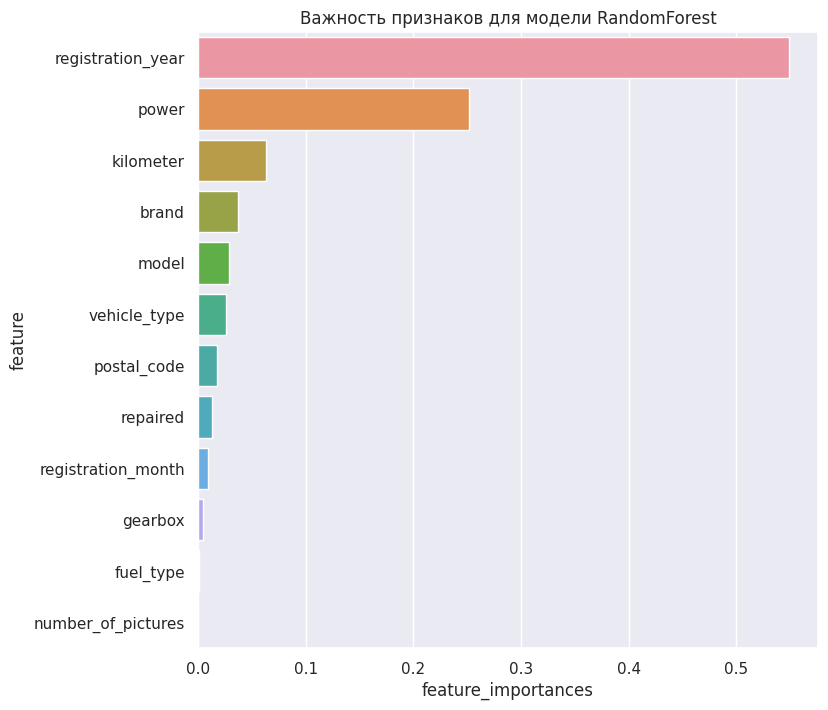

In [60]:
feature_importances = model_forest.feature_importances_
feature_importances_df = pd.DataFrame({'feature': list(features_train.columns),
                                      'feature_importances':feature_importances})
feature_importances_df = feature_importances_df.sort_values('feature_importances', ascending=False)
plt.figure(figsize=(8, 8))
plt.title('Важность признаков для модели RandomForest')
sns.barplot(x=feature_importances_df.feature_importances, y=feature_importances_df.feature);

По данному графику можно сделать вывод, что нет самыми важными признаками при построении модели являются год регистрации, количество л.с. и пробег (хоть пробег и намного ниже по важности).

Тип топлива оказался совсем не значимой фичей для модели.

### LightGBM

Выставим гиперпараметры. Выделим из трейн выборки часть на валидационную:

In [42]:
features_train_lgbm, features_valid_lgbm, target_train_lgbm, target_valid_lgbm = train_test_split(
    features_train, target_train, test_size=0.25, random_state=42)

In [43]:
model_lgbm = LGBMRegressor(boosting_type='gbdt', num_leaves=63,
                                    learning_rate=0.01, subsample=0.5, subsample_freq=20, 
                                    random_state=42, n_jobs=-1,
                                   num_boost_round=2000, early_stopping_rounds=50)

In [44]:
model_lgbm.fit(X=features_train_lgbm, y=target_train_lgbm, eval_set = (
    features_valid_lgbm, target_valid_lgbm), eval_metric='rmse')

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[1]	valid_0's rmse: 4354.86	valid_0's l2: 1.89648e+07
[2]	valid_0's rmse: 4321.66	valid_0's l2: 1.86767e+07
[3]	valid_0's rmse: 4288.86	valid_0's l2: 1.83944e+07
[4]	valid_0's rmse: 4256.45	valid_0's l2: 1.81174e+07
[5]	valid_0's rmse: 4224.5	valid_0's l2: 1.78464e+07
[6]	valid_0's rmse: 4192.89	valid_0's l2: 1.75803e+07
[7]	valid_0's rmse: 4161.72	valid_0's l2: 1.73199e+07
[8]	valid_0's rmse: 4130.82	valid_0's l2: 1.70637e+07
[9]	valid_0's rmse: 4100.42	valid_0's l2: 1.68134e+07
[10]	valid_0's rmse: 4070.42	valid_0's l2: 1.65683e+07
[11]	valid_0's rmse: 4040.64	valid_0's l2: 1.63268e+07
[12]	valid_0's rmse: 4011.32	valid_0's l2: 1.60907e+07
[13]	valid_0's rmse: 3982.46	valid_0's l2: 1.586e+07
[14]	valid_0's rmse: 3953.8	valid_0's l2:

[146]	valid_0's rmse: 2138.41	valid_0's l2: 4.57278e+06
[147]	valid_0's rmse: 2133.09	valid_0's l2: 4.55006e+06
[148]	valid_0's rmse: 2127.92	valid_0's l2: 4.52803e+06
[149]	valid_0's rmse: 2122.86	valid_0's l2: 4.50655e+06
[150]	valid_0's rmse: 2117.88	valid_0's l2: 4.48541e+06
[151]	valid_0's rmse: 2112.62	valid_0's l2: 4.46316e+06
[152]	valid_0's rmse: 2107.73	valid_0's l2: 4.44254e+06
[153]	valid_0's rmse: 2102.59	valid_0's l2: 4.42088e+06
[154]	valid_0's rmse: 2097.95	valid_0's l2: 4.40139e+06
[155]	valid_0's rmse: 2092.93	valid_0's l2: 4.38037e+06
[156]	valid_0's rmse: 2087.92	valid_0's l2: 4.3594e+06
[157]	valid_0's rmse: 2083.41	valid_0's l2: 4.34062e+06
[158]	valid_0's rmse: 2078.63	valid_0's l2: 4.32069e+06
[159]	valid_0's rmse: 2074.26	valid_0's l2: 4.30254e+06
[160]	valid_0's rmse: 2069.74	valid_0's l2: 4.28383e+06
[161]	valid_0's rmse: 2065.29	valid_0's l2: 4.26541e+06
[162]	valid_0's rmse: 2060.88	valid_0's l2: 4.24725e+06
[163]	valid_0's rmse: 2056.51	valid_0's l2: 4.229

[294]	valid_0's rmse: 1759.59	valid_0's l2: 3.09616e+06
[295]	valid_0's rmse: 1758.36	valid_0's l2: 3.09183e+06
[296]	valid_0's rmse: 1757.25	valid_0's l2: 3.08792e+06
[297]	valid_0's rmse: 1755.98	valid_0's l2: 3.08346e+06
[298]	valid_0's rmse: 1755.07	valid_0's l2: 3.08028e+06
[299]	valid_0's rmse: 1753.83	valid_0's l2: 3.07594e+06
[300]	valid_0's rmse: 1752.72	valid_0's l2: 3.07204e+06
[301]	valid_0's rmse: 1751.69	valid_0's l2: 3.06843e+06
[302]	valid_0's rmse: 1750.68	valid_0's l2: 3.06489e+06
[303]	valid_0's rmse: 1749.67	valid_0's l2: 3.06134e+06
[304]	valid_0's rmse: 1748.53	valid_0's l2: 3.05736e+06
[305]	valid_0's rmse: 1747.47	valid_0's l2: 3.05366e+06
[306]	valid_0's rmse: 1746.59	valid_0's l2: 3.05058e+06
[307]	valid_0's rmse: 1745.53	valid_0's l2: 3.04689e+06
[308]	valid_0's rmse: 1744.52	valid_0's l2: 3.04334e+06
[309]	valid_0's rmse: 1743.67	valid_0's l2: 3.04039e+06
[310]	valid_0's rmse: 1742.69	valid_0's l2: 3.03698e+06
[311]	valid_0's rmse: 1741.68	valid_0's l2: 3.03

[444]	valid_0's rmse: 1655.27	valid_0's l2: 2.73992e+06
[445]	valid_0's rmse: 1654.79	valid_0's l2: 2.73834e+06
[446]	valid_0's rmse: 1654.31	valid_0's l2: 2.73675e+06
[447]	valid_0's rmse: 1653.8	valid_0's l2: 2.73506e+06
[448]	valid_0's rmse: 1653.33	valid_0's l2: 2.73352e+06
[449]	valid_0's rmse: 1652.88	valid_0's l2: 2.73202e+06
[450]	valid_0's rmse: 1652.41	valid_0's l2: 2.73047e+06
[451]	valid_0's rmse: 1651.98	valid_0's l2: 2.72904e+06
[452]	valid_0's rmse: 1651.53	valid_0's l2: 2.72755e+06
[453]	valid_0's rmse: 1651.13	valid_0's l2: 2.72621e+06
[454]	valid_0's rmse: 1650.68	valid_0's l2: 2.72476e+06
[455]	valid_0's rmse: 1650.24	valid_0's l2: 2.7233e+06
[456]	valid_0's rmse: 1649.79	valid_0's l2: 2.7218e+06
[457]	valid_0's rmse: 1649.34	valid_0's l2: 2.72032e+06
[458]	valid_0's rmse: 1648.9	valid_0's l2: 2.71886e+06
[459]	valid_0's rmse: 1648.49	valid_0's l2: 2.71751e+06
[460]	valid_0's rmse: 1648.07	valid_0's l2: 2.71614e+06
[461]	valid_0's rmse: 1647.81	valid_0's l2: 2.71527e

[594]	valid_0's rmse: 1607.68	valid_0's l2: 2.58462e+06
[595]	valid_0's rmse: 1607.45	valid_0's l2: 2.58391e+06
[596]	valid_0's rmse: 1607.3	valid_0's l2: 2.58341e+06
[597]	valid_0's rmse: 1607.1	valid_0's l2: 2.58276e+06
[598]	valid_0's rmse: 1606.92	valid_0's l2: 2.58219e+06
[599]	valid_0's rmse: 1606.75	valid_0's l2: 2.58163e+06
[600]	valid_0's rmse: 1606.53	valid_0's l2: 2.58092e+06
[601]	valid_0's rmse: 1606.25	valid_0's l2: 2.58004e+06
[602]	valid_0's rmse: 1606.01	valid_0's l2: 2.57926e+06
[603]	valid_0's rmse: 1605.75	valid_0's l2: 2.57845e+06
[604]	valid_0's rmse: 1605.54	valid_0's l2: 2.57776e+06
[605]	valid_0's rmse: 1605.31	valid_0's l2: 2.57701e+06
[606]	valid_0's rmse: 1605.06	valid_0's l2: 2.57622e+06
[607]	valid_0's rmse: 1604.84	valid_0's l2: 2.57553e+06
[608]	valid_0's rmse: 1604.65	valid_0's l2: 2.57491e+06
[609]	valid_0's rmse: 1604.44	valid_0's l2: 2.57424e+06
[610]	valid_0's rmse: 1604.24	valid_0's l2: 2.5736e+06
[611]	valid_0's rmse: 1604.05	valid_0's l2: 2.57297

[744]	valid_0's rmse: 1585.02	valid_0's l2: 2.51228e+06
[745]	valid_0's rmse: 1584.93	valid_0's l2: 2.512e+06
[746]	valid_0's rmse: 1584.84	valid_0's l2: 2.51172e+06
[747]	valid_0's rmse: 1584.73	valid_0's l2: 2.51136e+06
[748]	valid_0's rmse: 1584.6	valid_0's l2: 2.51097e+06
[749]	valid_0's rmse: 1584.49	valid_0's l2: 2.5106e+06
[750]	valid_0's rmse: 1584.37	valid_0's l2: 2.51023e+06
[751]	valid_0's rmse: 1584.26	valid_0's l2: 2.50987e+06
[752]	valid_0's rmse: 1584.16	valid_0's l2: 2.50955e+06
[753]	valid_0's rmse: 1584.04	valid_0's l2: 2.50919e+06
[754]	valid_0's rmse: 1583.96	valid_0's l2: 2.50892e+06
[755]	valid_0's rmse: 1583.85	valid_0's l2: 2.50858e+06
[756]	valid_0's rmse: 1583.76	valid_0's l2: 2.50829e+06
[757]	valid_0's rmse: 1583.66	valid_0's l2: 2.50798e+06
[758]	valid_0's rmse: 1583.6	valid_0's l2: 2.50778e+06
[759]	valid_0's rmse: 1583.44	valid_0's l2: 2.50727e+06
[760]	valid_0's rmse: 1583.34	valid_0's l2: 2.50697e+06
[761]	valid_0's rmse: 1583.13	valid_0's l2: 2.5063e+0

[896]	valid_0's rmse: 1566.44	valid_0's l2: 2.45374e+06
[897]	valid_0's rmse: 1566.3	valid_0's l2: 2.4533e+06
[898]	valid_0's rmse: 1566.17	valid_0's l2: 2.45288e+06
[899]	valid_0's rmse: 1566.02	valid_0's l2: 2.45243e+06
[900]	valid_0's rmse: 1565.89	valid_0's l2: 2.45201e+06
[901]	valid_0's rmse: 1565.73	valid_0's l2: 2.4515e+06
[902]	valid_0's rmse: 1565.58	valid_0's l2: 2.45104e+06
[903]	valid_0's rmse: 1565.45	valid_0's l2: 2.45063e+06
[904]	valid_0's rmse: 1565.34	valid_0's l2: 2.45028e+06
[905]	valid_0's rmse: 1565.24	valid_0's l2: 2.44996e+06
[906]	valid_0's rmse: 1565.17	valid_0's l2: 2.44977e+06
[907]	valid_0's rmse: 1565.09	valid_0's l2: 2.4495e+06
[908]	valid_0's rmse: 1565.04	valid_0's l2: 2.44934e+06
[909]	valid_0's rmse: 1564.93	valid_0's l2: 2.44899e+06
[910]	valid_0's rmse: 1564.85	valid_0's l2: 2.44876e+06
[911]	valid_0's rmse: 1564.78	valid_0's l2: 2.44854e+06
[912]	valid_0's rmse: 1564.67	valid_0's l2: 2.44819e+06
[913]	valid_0's rmse: 1564.61	valid_0's l2: 2.448e+0

[1048]	valid_0's rmse: 1551.8	valid_0's l2: 2.40807e+06
[1049]	valid_0's rmse: 1551.72	valid_0's l2: 2.40784e+06
[1050]	valid_0's rmse: 1551.66	valid_0's l2: 2.40764e+06
[1051]	valid_0's rmse: 1551.59	valid_0's l2: 2.40744e+06
[1052]	valid_0's rmse: 1551.52	valid_0's l2: 2.4072e+06
[1053]	valid_0's rmse: 1551.46	valid_0's l2: 2.40704e+06
[1054]	valid_0's rmse: 1551.41	valid_0's l2: 2.40688e+06
[1055]	valid_0's rmse: 1551.39	valid_0's l2: 2.4068e+06
[1056]	valid_0's rmse: 1551.34	valid_0's l2: 2.40666e+06
[1057]	valid_0's rmse: 1551.32	valid_0's l2: 2.40659e+06
[1058]	valid_0's rmse: 1551.3	valid_0's l2: 2.40653e+06
[1059]	valid_0's rmse: 1551.26	valid_0's l2: 2.40642e+06
[1060]	valid_0's rmse: 1551.24	valid_0's l2: 2.40635e+06
[1061]	valid_0's rmse: 1551.16	valid_0's l2: 2.40611e+06
[1062]	valid_0's rmse: 1551.09	valid_0's l2: 2.40588e+06
[1063]	valid_0's rmse: 1551.02	valid_0's l2: 2.40565e+06
[1064]	valid_0's rmse: 1550.94	valid_0's l2: 2.40543e+06
[1065]	valid_0's rmse: 1550.87	vali

[1200]	valid_0's rmse: 1539.16	valid_0's l2: 2.36901e+06
[1201]	valid_0's rmse: 1539.12	valid_0's l2: 2.36889e+06
[1202]	valid_0's rmse: 1539.09	valid_0's l2: 2.36881e+06
[1203]	valid_0's rmse: 1539.06	valid_0's l2: 2.36872e+06
[1204]	valid_0's rmse: 1539.03	valid_0's l2: 2.36862e+06
[1205]	valid_0's rmse: 1538.99	valid_0's l2: 2.3685e+06
[1206]	valid_0's rmse: 1538.97	valid_0's l2: 2.36844e+06
[1207]	valid_0's rmse: 1538.95	valid_0's l2: 2.36838e+06
[1208]	valid_0's rmse: 1538.92	valid_0's l2: 2.36828e+06
[1209]	valid_0's rmse: 1538.89	valid_0's l2: 2.36819e+06
[1210]	valid_0's rmse: 1538.86	valid_0's l2: 2.3681e+06
[1211]	valid_0's rmse: 1538.82	valid_0's l2: 2.36796e+06
[1212]	valid_0's rmse: 1538.8	valid_0's l2: 2.36791e+06
[1213]	valid_0's rmse: 1538.78	valid_0's l2: 2.36784e+06
[1214]	valid_0's rmse: 1538.76	valid_0's l2: 2.36778e+06
[1215]	valid_0's rmse: 1538.74	valid_0's l2: 2.36771e+06
[1216]	valid_0's rmse: 1538.69	valid_0's l2: 2.36756e+06
[1217]	valid_0's rmse: 1538.66	val

[1350]	valid_0's rmse: 1530.86	valid_0's l2: 2.34353e+06
[1351]	valid_0's rmse: 1530.79	valid_0's l2: 2.34332e+06
[1352]	valid_0's rmse: 1530.74	valid_0's l2: 2.34315e+06
[1353]	valid_0's rmse: 1530.7	valid_0's l2: 2.34303e+06
[1354]	valid_0's rmse: 1530.66	valid_0's l2: 2.34291e+06
[1355]	valid_0's rmse: 1530.63	valid_0's l2: 2.34284e+06
[1356]	valid_0's rmse: 1530.59	valid_0's l2: 2.34272e+06
[1357]	valid_0's rmse: 1530.54	valid_0's l2: 2.34257e+06
[1358]	valid_0's rmse: 1530.51	valid_0's l2: 2.34247e+06
[1359]	valid_0's rmse: 1530.46	valid_0's l2: 2.34232e+06
[1360]	valid_0's rmse: 1530.43	valid_0's l2: 2.34222e+06
[1361]	valid_0's rmse: 1530.31	valid_0's l2: 2.34184e+06
[1362]	valid_0's rmse: 1530.19	valid_0's l2: 2.3415e+06
[1363]	valid_0's rmse: 1530.09	valid_0's l2: 2.34117e+06
[1364]	valid_0's rmse: 1529.99	valid_0's l2: 2.34087e+06
[1365]	valid_0's rmse: 1529.9	valid_0's l2: 2.3406e+06
[1366]	valid_0's rmse: 1529.82	valid_0's l2: 2.34035e+06
[1367]	valid_0's rmse: 1529.7	valid

[1500]	valid_0's rmse: 1524.78	valid_0's l2: 2.32496e+06
[1501]	valid_0's rmse: 1524.73	valid_0's l2: 2.3248e+06
[1502]	valid_0's rmse: 1524.68	valid_0's l2: 2.32465e+06
[1503]	valid_0's rmse: 1524.64	valid_0's l2: 2.32452e+06
[1504]	valid_0's rmse: 1524.59	valid_0's l2: 2.32438e+06
[1505]	valid_0's rmse: 1524.55	valid_0's l2: 2.32426e+06
[1506]	valid_0's rmse: 1524.52	valid_0's l2: 2.32415e+06
[1507]	valid_0's rmse: 1524.48	valid_0's l2: 2.32405e+06
[1508]	valid_0's rmse: 1524.44	valid_0's l2: 2.32393e+06
[1509]	valid_0's rmse: 1524.41	valid_0's l2: 2.32383e+06
[1510]	valid_0's rmse: 1524.38	valid_0's l2: 2.32372e+06
[1511]	valid_0's rmse: 1524.35	valid_0's l2: 2.32365e+06
[1512]	valid_0's rmse: 1524.32	valid_0's l2: 2.32354e+06
[1513]	valid_0's rmse: 1524.28	valid_0's l2: 2.32343e+06
[1514]	valid_0's rmse: 1524.26	valid_0's l2: 2.32336e+06
[1515]	valid_0's rmse: 1524.22	valid_0's l2: 2.32326e+06
[1516]	valid_0's rmse: 1524.19	valid_0's l2: 2.32315e+06
[1517]	valid_0's rmse: 1524.17	v

[1656]	valid_0's rmse: 1519.41	valid_0's l2: 2.3086e+06
[1657]	valid_0's rmse: 1519.4	valid_0's l2: 2.30858e+06
[1658]	valid_0's rmse: 1519.39	valid_0's l2: 2.30855e+06
[1659]	valid_0's rmse: 1519.38	valid_0's l2: 2.30851e+06
[1660]	valid_0's rmse: 1519.36	valid_0's l2: 2.30845e+06
[1661]	valid_0's rmse: 1519.33	valid_0's l2: 2.30837e+06
[1662]	valid_0's rmse: 1519.31	valid_0's l2: 2.30831e+06
[1663]	valid_0's rmse: 1519.29	valid_0's l2: 2.30824e+06
[1664]	valid_0's rmse: 1519.27	valid_0's l2: 2.30817e+06
[1665]	valid_0's rmse: 1519.26	valid_0's l2: 2.30816e+06
[1666]	valid_0's rmse: 1519.23	valid_0's l2: 2.30807e+06
[1667]	valid_0's rmse: 1519.22	valid_0's l2: 2.30804e+06
[1668]	valid_0's rmse: 1519.21	valid_0's l2: 2.308e+06
[1669]	valid_0's rmse: 1519.15	valid_0's l2: 2.30783e+06
[1670]	valid_0's rmse: 1519.12	valid_0's l2: 2.30771e+06
[1671]	valid_0's rmse: 1519.08	valid_0's l2: 2.30759e+06
[1672]	valid_0's rmse: 1519.06	valid_0's l2: 2.30755e+06
[1673]	valid_0's rmse: 1519.02	vali

[1802]	valid_0's rmse: 1514.53	valid_0's l2: 2.29379e+06
[1803]	valid_0's rmse: 1514.48	valid_0's l2: 2.29366e+06
[1804]	valid_0's rmse: 1514.44	valid_0's l2: 2.29353e+06
[1805]	valid_0's rmse: 1514.4	valid_0's l2: 2.2934e+06
[1806]	valid_0's rmse: 1514.36	valid_0's l2: 2.29328e+06
[1807]	valid_0's rmse: 1514.32	valid_0's l2: 2.29317e+06
[1808]	valid_0's rmse: 1514.29	valid_0's l2: 2.29308e+06
[1809]	valid_0's rmse: 1514.24	valid_0's l2: 2.29293e+06
[1810]	valid_0's rmse: 1514.21	valid_0's l2: 2.29285e+06
[1811]	valid_0's rmse: 1514.17	valid_0's l2: 2.29272e+06
[1812]	valid_0's rmse: 1514.14	valid_0's l2: 2.29261e+06
[1813]	valid_0's rmse: 1514.09	valid_0's l2: 2.29247e+06
[1814]	valid_0's rmse: 1514.04	valid_0's l2: 2.29233e+06
[1815]	valid_0's rmse: 1514.02	valid_0's l2: 2.29226e+06
[1816]	valid_0's rmse: 1513.98	valid_0's l2: 2.29214e+06
[1817]	valid_0's rmse: 1513.96	valid_0's l2: 2.29206e+06
[1818]	valid_0's rmse: 1513.92	valid_0's l2: 2.29197e+06
[1819]	valid_0's rmse: 1513.9	val

[1951]	valid_0's rmse: 1510.87	valid_0's l2: 2.28274e+06
[1952]	valid_0's rmse: 1510.88	valid_0's l2: 2.28275e+06
[1953]	valid_0's rmse: 1510.84	valid_0's l2: 2.28263e+06
[1954]	valid_0's rmse: 1510.83	valid_0's l2: 2.2826e+06
[1955]	valid_0's rmse: 1510.82	valid_0's l2: 2.28257e+06
[1956]	valid_0's rmse: 1510.77	valid_0's l2: 2.28243e+06
[1957]	valid_0's rmse: 1510.76	valid_0's l2: 2.28239e+06
[1958]	valid_0's rmse: 1510.72	valid_0's l2: 2.28227e+06
[1959]	valid_0's rmse: 1510.71	valid_0's l2: 2.28225e+06
[1960]	valid_0's rmse: 1510.71	valid_0's l2: 2.28223e+06
[1961]	valid_0's rmse: 1510.7	valid_0's l2: 2.28221e+06
[1962]	valid_0's rmse: 1510.69	valid_0's l2: 2.28217e+06
[1963]	valid_0's rmse: 1510.68	valid_0's l2: 2.28215e+06
[1964]	valid_0's rmse: 1510.66	valid_0's l2: 2.2821e+06
[1965]	valid_0's rmse: 1510.66	valid_0's l2: 2.2821e+06
[1966]	valid_0's rmse: 1510.65	valid_0's l2: 2.28205e+06
[1967]	valid_0's rmse: 1510.64	valid_0's l2: 2.28204e+06
[1968]	valid_0's rmse: 1510.63	vali

LGBMRegressor(early_stopping_rounds=50, learning_rate=0.01,
              num_boost_round=2000, num_leaves=63, random_state=42,
              subsample=0.5, subsample_freq=20)

In [45]:
target_train_pred = model_lgbm.predict(features_train_lgbm)
target_valid_pred = model_lgbm.predict(features_valid_lgbm)

print("LigthGBM RMSE Train: {}\nLigthGBM RMSE Valid: {}".format(mean_squared_error(target_train_lgbm, target_train_pred)**0.5,
                                             mean_squared_error(target_valid_lgbm, target_valid_pred)**0.5))

LigthGBM RMSE Train: 1407.7950356677552
LigthGBM RMSE Valid: 1509.17346005288


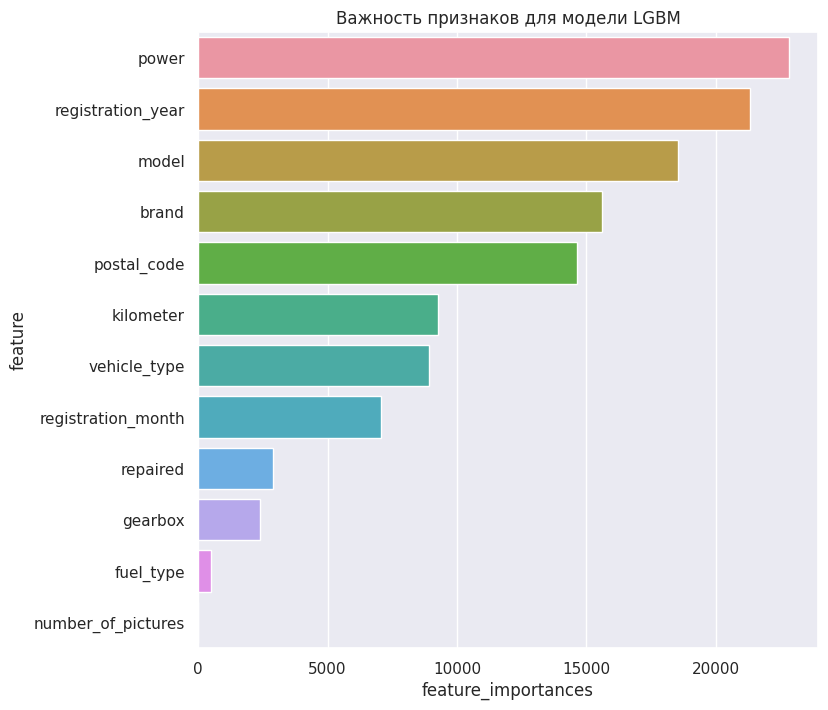

In [59]:
feature_importances = model_lgbm.feature_importances_
feature_importances_df = pd.DataFrame({'feature': list(features_train.columns),
                                      'feature_importances':feature_importances})
feature_importances_df = feature_importances_df.sort_values('feature_importances', ascending=False)
plt.figure(figsize=(8, 8))
plt.title('Важность признаков для модели LGBM')
sns.barplot(x=feature_importances_df.feature_importances, y=feature_importances_df.feature);

При построении модели LightGBM самыми выделяющимися по значимости признаками стали количество л.с., год регистрации, модель автомобиля. Тип топлива как и в модели леса имеет самую низкую значимость.

Оценив поверхностно результаты, можно выделить модель LightGBM, как наиболее качественную по метрике RMSE. В рабочем варианте было использовано 3270 итераций, что позволило еще больше сократить ошибку.

В итоговой работе было принято решение оставить 2000 итераций для сокращения времени выполнения обучения/предсказания. Локально бустинг работает быстрее.

## Анализ моделей

А теперь подробно рассмотрим время обучения моделей, время предсказания и сравним качество предсказаний.

Время выполнения кода будем измерять с помощью магической функции в JupyterNotebook - `%timeit`

### AdaBoost

In [47]:
%timeit model_ada.fit(features_train, target_train)

37.7 s ± 2.7 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [48]:
%timeit model_ada.predict(features_train)

1.63 s ± 77.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [49]:
ada_score = ((cross_val_score(model_ada, features_train, target_train, scoring='neg_mean_squared_error') * -1)**0.5).mean()

In [50]:
print("Adaboost RMSE Valid: {}".format(ada_score.round(2)))

Adaboost RMSE Valid: 2496.94


Время обучения - 38 секунд;

Время предсказания - 1.6 секунд;

Качество модели - 2496.94

### Random Forest

In [51]:
%timeit model_forest.fit(features_train, target_train)

2min 48s ± 4.23 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [52]:
%timeit model_forest.predict(features_train)

8.92 s ± 424 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [53]:
forest_score = ((cross_val_score(model_forest, features_train, target_train, scoring='neg_mean_squared_error') * -1)**0.5).mean()

In [54]:
print("RandomForest RMSE Valid: {}".format(forest_score.round(2)))

RandomForest RMSE Valid: 1549.35


Время обучения - 2 минуты 48 секунд;

Время предсказания - 9 секунд;

Качество модели - 1549.35

### LightGBM

In [55]:
%timeit model_lgbm.fit(X=features_train_lgbm, y=target_train_lgbm, eval_set = (features_valid_lgbm, target_valid_lgbm), eval_metric='rmse', verbose=0)

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
47.6 s ± 730 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [56]:
%timeit model_lgbm.predict(features_test)

21 s ± 156 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [57]:
target_train_pred = model_lgbm.predict(features_train_lgbm)
target_valid_pred = model_lgbm.predict(features_valid_lgbm)

print("LigthGBM RMSE Valid: {}".format(mean_squared_error(target_valid_lgbm, target_valid_pred)**0.5))

LigthGBM RMSE Valid: 1509.17346005288


Время обучения - 48 секунд;

Время предсказания - 21 секунда;

Качество модели - 1509.17

## Проверка качества на тестовых данных

По результатам анализа более качественная модель - модель LightGBM. При этом скорость предсказания меньше у модели Random Forest.

Мы остановим свой выбор на LightGBM и проверим модель на тестовых данных.

In [58]:
target_test_pred = model_lgbm.predict(features_test)

print("LigthGBM RMSE Test: {}".format(mean_squared_error(target_test, target_test_pred)**0.5))

LigthGBM RMSE Test: 1500.1870259712061


## Общий вывод по работе

- В работе были выполнены все поставленные задачи: достигнуто необходимое качество по выбранной заказчиком метрике, имеется несколько вариантов для выбора подходящей по скорости обучения/предсказания модели, одна из моделей реализована на базе градиентного бустинга с использованием библиотеки LightGBM.
    
---

- На первом этапе были выполнены необходимые действия для предобработки данных: приведены к стандарту названия столбцов, удалены малоинформативные столбцы, категориальные значения преобразованы в числовые, проведена проверка на мультиколлинеарность, использованы умные алгоритмы заполнения пропусков. Были удалены аномальные значения.

    Здесь также стоит отметить, что необходимо поработать с процессом сбора данных: было очень много                   пропущенных данных и аномальных значений, особенно в искомом признаке - много нулевых значений в                   столбце "цена".
    
---

- Обучили три модели: модель AdaBoost, случайный лес, модель LightGBM.
    
---

- По точности лидером является модель LightGBM. При этом ошибка не намного меньше модели Random Forest. Если интересует более быстрое предсказание, можно выбрать RandomForest. Мы в итоге выбрали модель LightGBM. Чтобы получить еще более точные результаты можно увеличить количество итераций.
    
